In [ ]:
# Import required packages
import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
from torchtext import data
from torchtext import datasets
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

## **QUESTION 1**

**PART A: Build a Markov (n-gram) language model**

We built a markov model (n gram=trigram) model. Torch package was used to extract the IMDB dataset and the function generates trigrams is passed to the preprocessing argument in the data. 'Field' function helps splitting each review into trigrams and 'freqs' function is used to get the count of each trigram. This data can be used to calculate probabilties and predictions are made my sampling these probabilities.

In [ ]:
# split each review into tokens with 3-gram
def create_trigram(x):
    res = []
    n_grams = list(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        res.append(' '.join(n_gram))
    return res

In [ ]:
SEED = 7

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load IMDB datasets
TEXT = data.Field(tokenize='spacy',preprocessing=create_trigram) # tokenize reviews based on 3-gram model
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
print(vars(train_data.examples[0]))

# Split data into train and test data at the ratio of 80:20
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.8)
TEXT.build_vocab(train_data) # create a dictionary from train data
dictionary = dict(TEXT.vocab.freqs) # calculate frequency of trigrams
len(dictionary) # of components in dictionary

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 9.31MB/s]


{'text': ['The year 2005', 'year 2005 saw', '2005 saw no', 'saw no fewer', 'no fewer than', 'fewer than 3', 'than 3 filmed', '3 filmed productions', 'filmed productions of', 'productions of H.', 'of H. G.', 'H. G. Wells', "G. Wells '", "Wells ' great", "' great novel", 'great novel ,', 'novel , "', ', " War', '" War of', 'War of the', 'of the Worlds', 'the Worlds "', 'Worlds " .', '" . This', '. This is', 'This is perhaps', 'is perhaps the', 'perhaps the least', 'the least well', 'least well -', 'well - known', '- known and', 'known and very', 'and very probably', 'very probably the', 'probably the best', 'the best of', 'best of them', 'of them .', 'them . No', '. No other', 'No other version', 'other version of', 'version of WotW', 'of WotW has', 'WotW has ever', 'has ever attempted', 'ever attempted not', 'attempted not only', 'not only to', 'only to present', 'to present the', 'present the story', 'the story very', 'story very much', 'very much as', 'much as Wells', 'as Wells wrote'

3201317

In [ ]:
dictionary['the three leads'] # just an example

8

In [ ]:
mrkv = pd.DataFrame.from_dict(dictionary,orient="index") # convert dictionary into pandas dataframe
mrkv = mrkv.reset_index() # remove index

mrkv.columns = ['trigrams','count'] # rename columns
mrkv['bigrams'] =mrkv.trigrams.apply(lambda x: " ".join(x.split(' ')[:2])) # create bigrams
mrkv['output'] =mrkv.trigrams.apply(lambda x: x.split(' ')[2])
inp_cnt = pd.DataFrame(mrkv.groupby("bigrams",as_index=False)["count"].sum()) # count frequency of bigrams model

In [ ]:
inp_cnt

,bigrams,count
0,A Turkish,1
1,"\t """,2
2,\t Alex,1
3,\t As,3
4,\t At,1
...,...,...
1218998,… <,1
1218999,… although,1
1219000,… but,2
1219001,₤100 per,1


In [ ]:
mrkv.head() # final dataframe for markov model

,trigrams,count,bigrams,output
0,"OK , I",31,"OK ,",I
1,", I did",208,", I",did
2,I did n't,883,I did,n't
3,did n't know,179,did n't,know
4,n't know what,211,n't know,what


**PART B: Change the output appropriately in ‘Simple Sentiment Analysis.ipynb’ to build an LSTM based language model. Plot the training performance as a function of epochs/iterations.**

In [ ]:
SEED = 7
# use seed for reproducibility

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy') # tokenize sentences
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL) # import dataset

In [ ]:
# check data size of train and test data
print(f'Number of training examples in data: {len(train_data)}')
print(f'Number of testing examples in data: {len(test_data)}')

Number of training examples in data: 25000
Number of testing examples in data: 25000


In [ ]:
print(vars(train_data.examples[0])) # observe one example 

# split data into train and test data
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.32) 

{'text': ['The', 'year', '2005', 'saw', 'no', 'fewer', 'than', '3', 'filmed', 'productions', 'of', 'H.', 'G.', 'Wells', "'", 'great', 'novel', ',', '"', 'War', 'of', 'the', 'Worlds', '"', '.', 'This', 'is', 'perhaps', 'the', 'least', 'well', '-', 'known', 'and', 'very', 'probably', 'the', 'best', 'of', 'them', '.', 'No', 'other', 'version', 'of', 'WotW', 'has', 'ever', 'attempted', 'not', 'only', 'to', 'present', 'the', 'story', 'very', 'much', 'as', 'Wells', 'wrote', 'it', ',', 'but', 'also', 'to', 'create', 'the', 'atmosphere', 'of', 'the', 'time', 'in', 'which', 'it', 'was', 'supposed', 'to', 'take', 'place', ':', 'the', 'last', 'year', 'of', 'the', '19th', 'Century', ',', '1900', '\x85 ', 'using', 'Wells', "'", 'original', 'setting', ',', 'in', 'and', 'near', 'Woking', ',', 'England.<br', '/><br', '/>IMDb', 'seems', 'unfriendly', 'to', 'what', 'they', 'regard', 'as', '"', 'spoilers', '"', '.', 'That', 'might', 'apply', 'with', 'some', 'films', ',', 'where', 'the', 'ending', 'might'

In [ ]:
print(f'Number of training examples: {len(train_data)}') # 8000
print(f'Number of validation examples: {len(valid_data)}') # 17000
print(f'Number of testing examples: {len(test_data)}') # 25000

Number of training examples: 8000
Number of validation examples: 17000
Number of testing examples: 25000


In [ ]:
TEXT.build_vocab(train_data, max_size=1500) # build vocabulary
LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 1502
Unique tokens in LABEL vocabulary: 2


In [ ]:
BATCH_SIZE = 16 # specify batch size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim,hidden_dim,BATCH_SIZE,output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, output_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):        
        embedded = self.embedding(x)
        output, (hidden,cell) = self.rnn(embedded)
        dim = output.size()
        output = output.view(-1, output.shape[2])
        output1 = F.log_softmax(output,dim=1)
        
        if BATCH_SIZE==dim[1]:
            output1 = output1.view(-1,OUTPUT_DIM,BATCH_SIZE)
        else:
            output1 = output1.view(dim[1],OUTPUT_DIM,-1)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]       
        return output1

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(TEXT.vocab)
model = RNN(INPUT_DIM, EMBEDDING_DIM,HIDDEN_DIM,BATCH_SIZE,OUTPUT_DIM) # built a RNN model

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2) # SGD optimizer
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(model, iterator, optimizer, criterion,BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()   
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [ ]:
def evaluate(model, iterator, criterion, BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator: 
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#Train loss and accuracy

N_EPOCHS = 10 # specify the number of epochs
train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, BATCH_SIZE)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_losses.append(train_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

    print(f'Best validation loss: {best_valid_loss:.3f}% |')

| Epoch: 01 | Train Loss: 6.974 | Train Acc: 6.95% | Val. Loss: 7.306 | Val. Acc: 0.04% |
Best validation loss: 7.306% |
| Epoch: 02 | Train Loss: 6.786 | Train Acc: 7.19% | Val. Loss: 7.296 | Val. Acc: 0.04% |
Best validation loss: 7.296% |
| Epoch: 03 | Train Loss: 6.724 | Train Acc: 7.01% | Val. Loss: 7.282 | Val. Acc: 0.04% |
Best validation loss: 7.282% |
| Epoch: 04 | Train Loss: 6.642 | Train Acc: 7.15% | Val. Loss: 7.249 | Val. Acc: 0.04% |
Best validation loss: 7.249% |
| Epoch: 05 | Train Loss: 6.536 | Train Acc: 6.72% | Val. Loss: 7.177 | Val. Acc: 0.04% |
Best validation loss: 7.177% |
| Epoch: 06 | Train Loss: 6.414 | Train Acc: 6.55% | Val. Loss: 7.097 | Val. Acc: 0.04% |
Best validation loss: 7.097% |
| Epoch: 07 | Train Loss: 6.308 | Train Acc: 6.54% | Val. Loss: 7.037 | Val. Acc: 0.04% |
Best validation loss: 7.037% |
| Epoch: 08 | Train Loss: 6.206 | Train Acc: 6.63% | Val. Loss: 7.002 | Val. Acc: 0.04% |
Best validation loss: 7.002% |
| Epoch: 09 | Train Loss: 6.133 

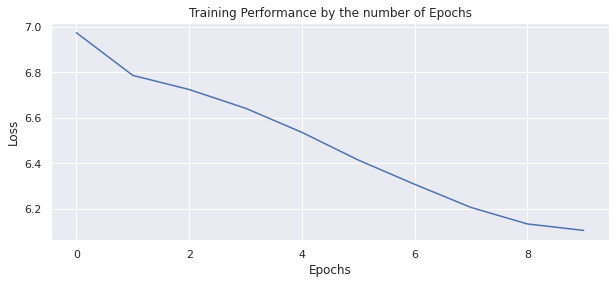

In [ ]:
import seaborn as sns
sns.set()
plt.figure(figsize=(10,4))
plt.plot(train_losses)
plt.title("Training Performance by the number of Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
#Test loss and accuracy

model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, BATCH_SIZE)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 6.977 | Test Acc: 0.04%


## **QUESTION 2: For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality.**


Markov model we went with the trigrams and there was not computational complexity in computing the probabilities and prediction. For LSTM, there was an input layer followed by embedding then lstm layer. The input was the tokenized and output can also the tokenized text offsetted by 1 place. For instance, if input is [This,is,my,favorite,movie] then output is [is,my,favorite,movie, ...

1.  We took 30% training data with max 1000 words with batch size 16 to train our lstm model.
2. If we increased the number of words then the model couldn't be loaded successfullyas there was insufficient memory
3. If we rose size of the training data to higher percentage such as 65% or 75%, the notebook got disconnected from the server (crashed). 
4. When we decreased the batch size to 1 or 2 then model took longer time to train and when we increased it to 64 or 128 then there was memory error in which we encountered (higher complexity). We settled at 'batch size' as 16.
5. Due to this limited training size and words, the quality of reviews formed by prediction was affected considerably. The prediction didn't give out a plausible sentence as we would have liked.



## **QUESTION 3: For each model, starting with the phrase ”My favorite movie ”, sample the next few words and create a 20 word generated review.**

Prediction: Markov Model

In [ ]:
def create_sentence(sentence,no_preds,predict_length):

    predict_length -= len(sentence.split(" ")) 

    for j in range(0,no_preds):
        pred_sentence = sentence
        bi = " ".join(pred_sentence.split(" ")[1:])

        for i in range(0,predict_length):
            poss_pred = np.array(mrkv.output[mrkv.bigrams==bi])
            scores = np.array(mrkv[mrkv.bigrams==bi]['count'])
            length = inp_cnt[inp_cnt.bigrams==bi]['count']
            probs = scores/length.iloc[0]
            pred = random.choice(list(enumerate(probs)))[0]
            pred = poss_pred[pred]
            pred_sentence = pred_sentence + " " + pred
            bi = " ".join([bi.split(" ")[1],pred])

        print("Generated Review "+str(j+1)+": ",pred_sentence+"\n")
create_sentence("My favorite movie",5,20)

Generated Review 1:  My favorite movie ( either Ben or Arthur , a magnificent job throughout , enjoying a night on Saturday (

Generated Review 2:  My favorite movie of about 2 steps above Ed Wood.<br /><br />Not being a 30 second gag on a shooting

Generated Review 3:  My favorite movie Dawn of the General , that incident is downright painful to watch.<br /><br />Ritter 's character ranks

Generated Review 4:  My favorite movie a 45 minute Boy 's main methods of intrigue , neither very good female lead begins a

Generated Review 5:  My favorite movie of Luchino Visconti is working way too standard . One pilot has a prop for the jokes



Prediction: LSTM Model

In [ ]:
for j in range(5):
    inp =torch.tensor([[TEXT.vocab.stoi["my"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
    for i in range(17):
        op = model(inp)
        op = op.squeeze(0)
        op = op[:,op.size()[1]-1].detach().cpu().numpy()
        op = np.sort(op)[::-1]
        op = op[:500] 
        new_inp = torch.tensor(np.where(op==np.random.choice(op,1)),device="cuda:0")
        inp = torch.cat((inp,new_inp))
    
    generated_text = ""
    for val in inp:
        generated_text = generated_text + " " + TEXT.vocab.itos[val]
    print("Generated Review "+str(j+1)+": ",generated_text+"\n")

Generated Review 1:   my favorite movie nothing thought now sense least must name and black it acting n't about wo can As himself

Generated Review 2:   my favorite movie cast awful seemed All day got remember come watch world never makes first everything /><br drama this

Generated Review 3:   my favorite movie We To almost plays little down minutes them way He But hard make i people picture who

Generated Review 4:   my favorite movie ( almost people old children always could money women who played & sort star through may father

Generated Review 5:   my favorite movie well father felt played She end plot probably around pretty nothing You film together live since man

